Projekat 2

Filip Nikolić   
Jovan Dimitrijević

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler, QuantileTransformer
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.mixture import GaussianMixture
from sklearn.covariance import EllipticEnvelope
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA

Pomoćne funkcije

In [9]:
def impute_outliers_with_median_for_all_columns(df):
    # Iterate over each column in the DataFrame
    for column in df.columns:
        # Skip non-numeric columns
        if df[column].dtype.kind in 'bifc':  # b=bool, i=int, f=float, c=complex
            # Calculate the Z-scores of each data point in the column
            z_scores = np.abs(stats.zscore(df[column], nan_policy='omit'))
            
            # Define the threshold for identifying outliers
            threshold = 3
            
            # Identify outliers
            outliers = z_scores > threshold
            
            # Calculate the median of the column without outliers
            median_value = df[column][~outliers].median()
            
            # Impute outliers with the median value
            df.loc[outliers, column] = median_value
    
    return df

# Function to detect and exclude outliers using Elliptic Envelope
def exclude_outliers_elliptic_envelope(df, contamination=0.05):
    # contamination parameter is the proportion of outliers expected in the data
    elliptic_env = EllipticEnvelope(contamination=contamination, random_state=42)
    preds = elliptic_env.fit_predict(df)
    # Filter out the outliers
    df_filtered = df[preds != -1]
    return df_filtered

# Function to convert time string to minutes past midnight
def time_to_minutes(time_str):
  hours, minutes = map(int, time_str.split(':'))
  return hours * 60 + minutes

Sredjivanje dataset-a

In [10]:
# Load the CSV file
df = pd.read_csv('books_original.csv')

# Remove the last 32 columns
df = df.iloc[:, :-32]

# Convert the 'time' column to datetime objects and then format to 24-hour time
df['Time'] = pd.to_datetime(df['Time']).dt.strftime('%H:%M')
df['Time'] = df['Time'].apply(time_to_minutes)

label_encoder = LabelEncoder()
df['Product-Name'] = label_encoder.fit_transform(df['Product-Name'])
df['Item-Status'] = label_encoder.fit_transform(df['Item-Status'])
df['Currency'] = label_encoder.fit_transform(df['Currency'])
df['Ship-City'] = label_encoder.fit_transform(df['Ship-City'])
df['Ship-State'] = label_encoder.fit_transform(df['Ship-State'])
df['Category'] = label_encoder.fit_transform(df['Category'])
df['Author'] = label_encoder.fit_transform(df['Author'])
df['Publication'] = label_encoder.fit_transform(df['Publication'])

# Drop the columns you don't want to use for clustering
df = df.drop(['ID', 'Purchase-date', 'Quarter', 'Date', 'Customer ID', 'Gender.2', 'Item-Status', 'Currency'], axis=1)

# Save the modified DataFrame to a new CSV file
df.to_csv('books.csv', index=False)

Priprema podataka za treniranje K-means modela

In [11]:
df = pd.read_csv('books.csv')

# Standardize the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

df_cleaned = impute_outliers_with_median_for_all_columns(df)  # Data without outliers

Primena PCA algoritma i odredjvanje Elbow krive

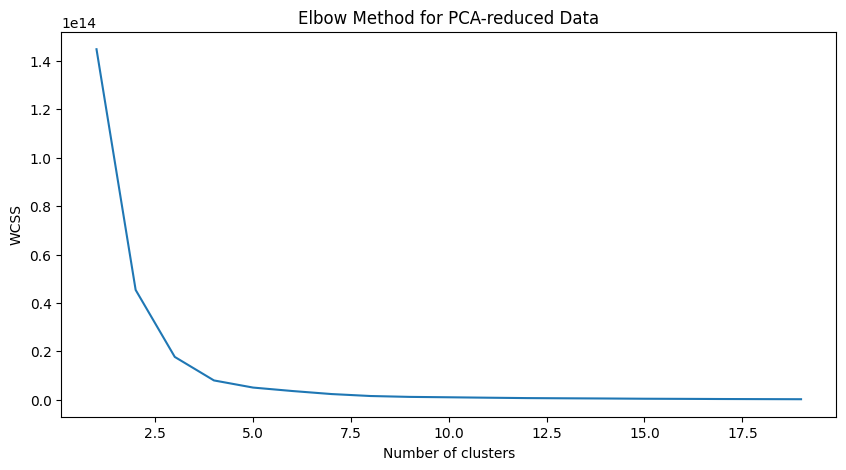

In [12]:
# Apply PCA for data reduction, automatically determining the number of components
pca = PCA().fit(df_cleaned)  # Fit PCA on data without outliers
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
n_components = np.where(cumulative_variance >= 0.95)[0][0] + 1  # Number of components to explain 95% variance
pca = PCA(n_components=n_components)
df_pca = pca.fit_transform(df_cleaned)  # Transform data

# Elbow method for the PCA-reduced data
wcss = []
for i in range(1, 20):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(df_pca)
    wcss.append(kmeans.inertia_)

# Plotting the results onto a line graph to observe 'The elbow'
plt.figure(figsize=(10, 5))
plt.plot(range(1, 20), wcss)
plt.title('Elbow Method for PCA-reduced Data')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

Primena K-means algoritma

In [13]:
# Choose the number of clusters
n_clusters = int(input("Enter the optimal number of clusters: "))   #7-8 je optimalan broj za nas slucaj

# Applying KMeans on the PCA-reduced data
kmeans = KMeans(n_clusters=n_clusters)
clusters = kmeans.fit_predict(df_pca)

# Adding cluster labels back to the DataFrame without outliers
df_cleaned['cluster'] = clusters

# Save the DataFrame with cluster labels
df_cleaned.to_csv('books_clustered-kmeans.csv', index=False)

# Calculate the silhouette score for the PCA-reduced data
silhouette_avg = silhouette_score(df_pca, clusters)
print("Silhouette Score: ", silhouette_avg)

/Users/filipnikolic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette Score:  0.6906178053192541


Vizuelizacija centroida klastera

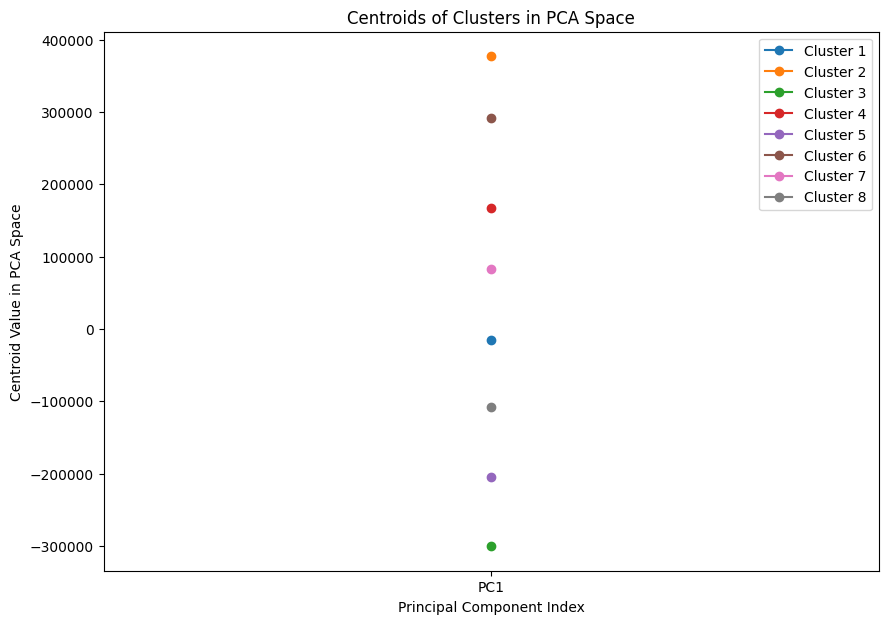

In [14]:
# Visualization of Centroids in PCA Space
plt.figure(figsize=(10, 7))
centroids = kmeans.cluster_centers_
for i, centroid in enumerate(centroids):
  plt.plot(centroid, marker='o', label=f'Cluster {i+1}')

plt.xticks(range(n_components), [f'PC{i+1}' for i in range(n_components)])
plt.xlabel('Principal Component Index')
plt.ylabel('Centroid Value in PCA Space')
plt.title('Centroids of Clusters in PCA Space')
plt.legend()
plt.show()

Ostale K-means vizuelizacije

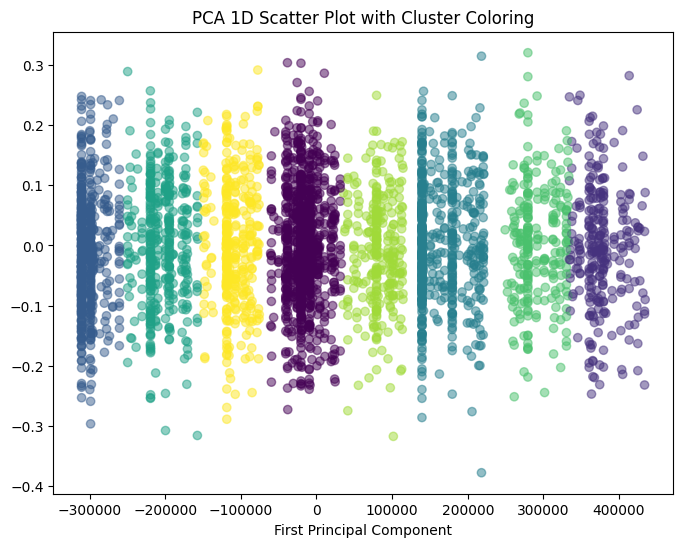

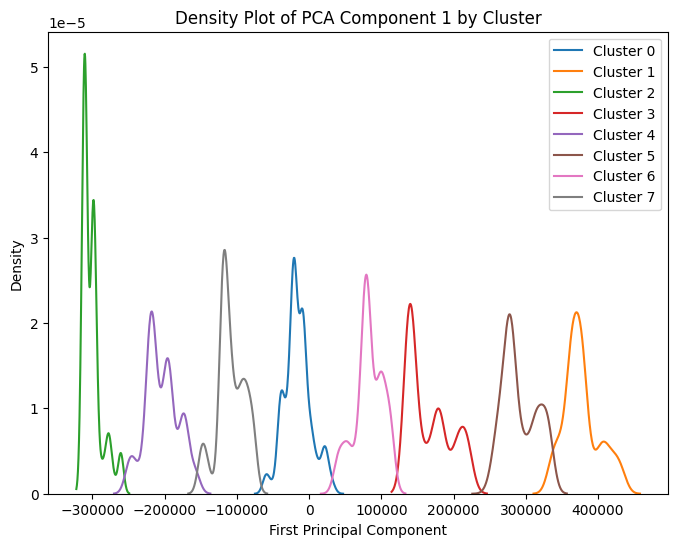

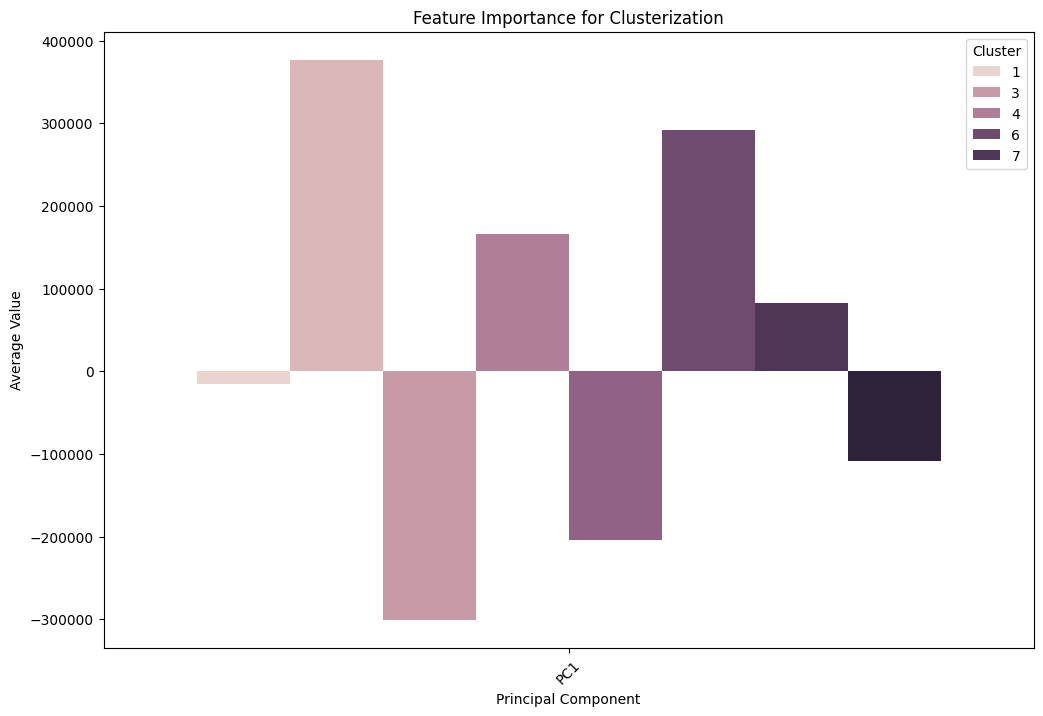

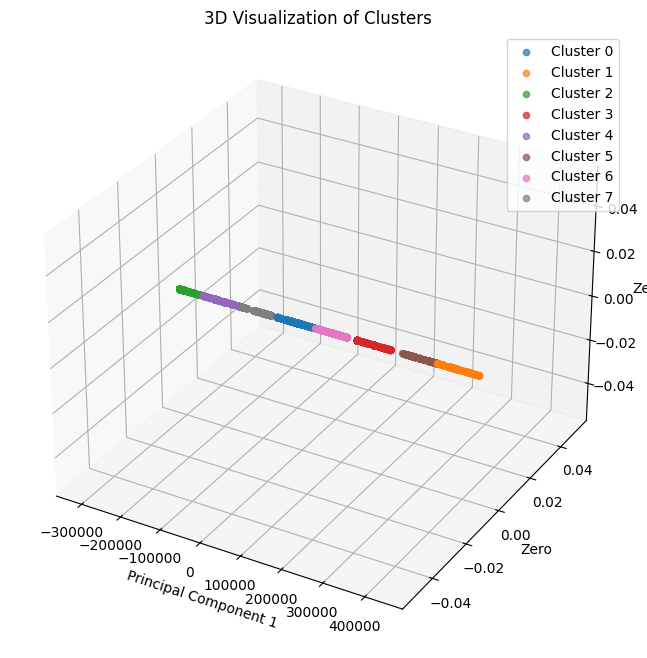

In [15]:
plt.figure(figsize=(8, 6))
# Apply a small random jitter to the y-axis
jitter = np.random.normal(0, 0.1, size=df_pca[:, 0].shape)
plt.scatter(df_pca[:, 0], jitter, c=clusters, cmap='viridis', alpha=0.5)
plt.xlabel('First Principal Component')
plt.title('PCA 1D Scatter Plot with Cluster Coloring')
plt.show()

# Create a DataFrame for easier plotting
plot_df = pd.DataFrame({'PCA1': df_pca[:, 0], 'Cluster': clusters})

plt.figure(figsize=(8, 6))
# Plot density for each cluster
for cluster in np.unique(clusters):
    sns.kdeplot(plot_df[plot_df['Cluster'] == cluster]['PCA1'], label=f'Cluster {cluster}')
plt.xlabel('First Principal Component')
plt.title('Density Plot of PCA Component 1 by Cluster')
plt.legend()
plt.show()

# Calculate average feature values for each cluster
cluster_centers_df = pd.DataFrame(kmeans.cluster_centers_, columns=[f'PC{i+1}' for i in range(n_components)])
cluster_centers_df['Cluster'] = range(1, n_clusters + 1)

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(data=cluster_centers_df.melt(id_vars='Cluster'), x='variable', y='value', hue='Cluster')
plt.title('Feature Importance for Clusterization')
plt.xlabel('Principal Component')
plt.ylabel('Average Value')
plt.legend(title='Cluster')
plt.xticks(rotation=45)
plt.show()

# Visualize clusters in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for each cluster
for cluster in np.unique(clusters):
    cluster_indices = np.where(clusters == cluster)
    ax.scatter(df_pca[cluster_indices, 0], np.zeros_like(cluster_indices), np.zeros_like(cluster_indices), label=f'Cluster {cluster}', alpha=0.7)

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Zero')
ax.set_zlabel('Zero')
ax.set_title('3D Visualization of Clusters')
plt.legend()
plt.show()

Priprema podataka za treniranje modela Hierarhijske klasterizacije

In [16]:
df = pd.read_csv('books.csv')

# Apply outlier transformation using RobustScaler
scaler = RobustScaler()
df_scaled = scaler.fit_transform(df)

Primena PCA algoritma i iscrtavanje dendograma kod Hierarhijske klasterizacije

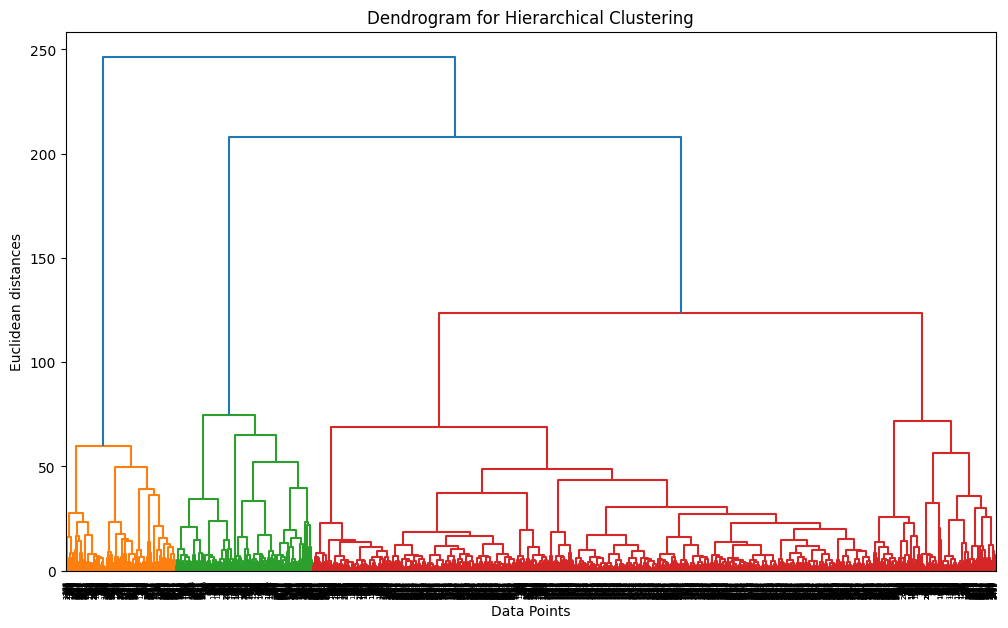

In [17]:
# Apply PCA for feature reduction
pca = PCA(n_components=0.95)  # Keep 95% of the variance
df_reduced = pca.fit_transform(df_scaled)

# Hierarchical Clustering on reduced feature space
Z = linkage(df_reduced, method='ward')
plt.figure(figsize=(12, 7))
dendrogram(Z)
plt.title('Dendrogram for Hierarchical Clustering')
plt.xlabel('Data Points')
plt.ylabel('Euclidean distances')
plt.show()

Primena algoritma Hijerarhijske klasterizacije

In [18]:
n_clusters_hierarchical = int(input("Enter the number of clusters (from dendrogram): "))
hc = AgglomerativeClustering(n_clusters=n_clusters_hierarchical, affinity='euclidean', linkage='ward')
hc_clusters = hc.fit_predict(df_reduced)

# Calculate silhouette score
silhouette_avg_hierarchical = silhouette_score(df_reduced, hc_clusters)
print("Silhouette Score for Hierarchical Clustering: ", silhouette_avg_hierarchical)

# Add cluster labels to the original DataFrame
df['cluster'] = hc_clusters
df.to_csv('books_clustered-hierarchical.csv', index=False)

/Users/filipnikolic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


Silhouette Score for Hierarchical Clustering:  0.3600968947614996


Vizuelizacija centroida klastera

/Users/filipnikolic/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


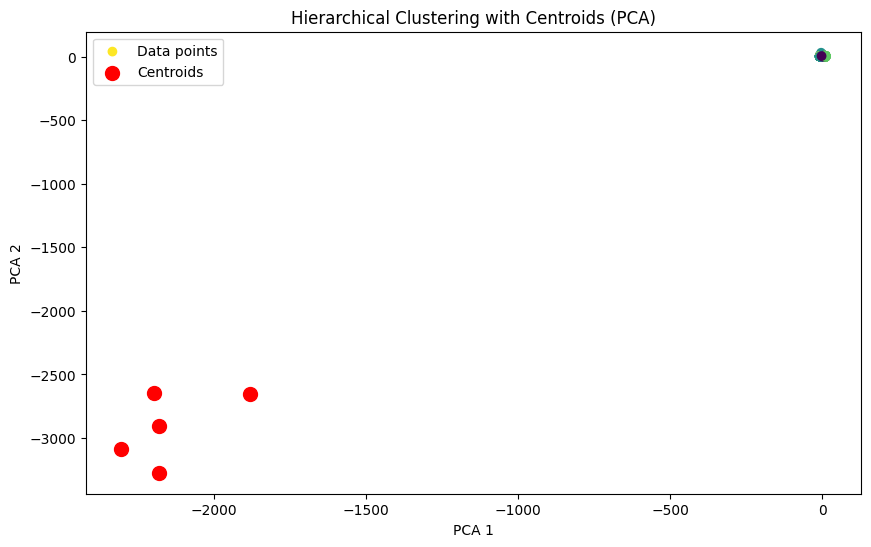

In [19]:
# Calculate centroids in reduced feature space
centroids_reduced = pca.transform(df.groupby('cluster').mean())

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(df_reduced[:, 0], df_reduced[:, 1], c=hc_clusters, cmap='viridis', label='Data points')
plt.scatter(centroids_reduced[:, 0], centroids_reduced[:, 1], s=100, c='red', label='Centroids')
plt.title('Hierarchical Clustering with Centroids (PCA)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()
plt.show()

Feature importance odredjivanje

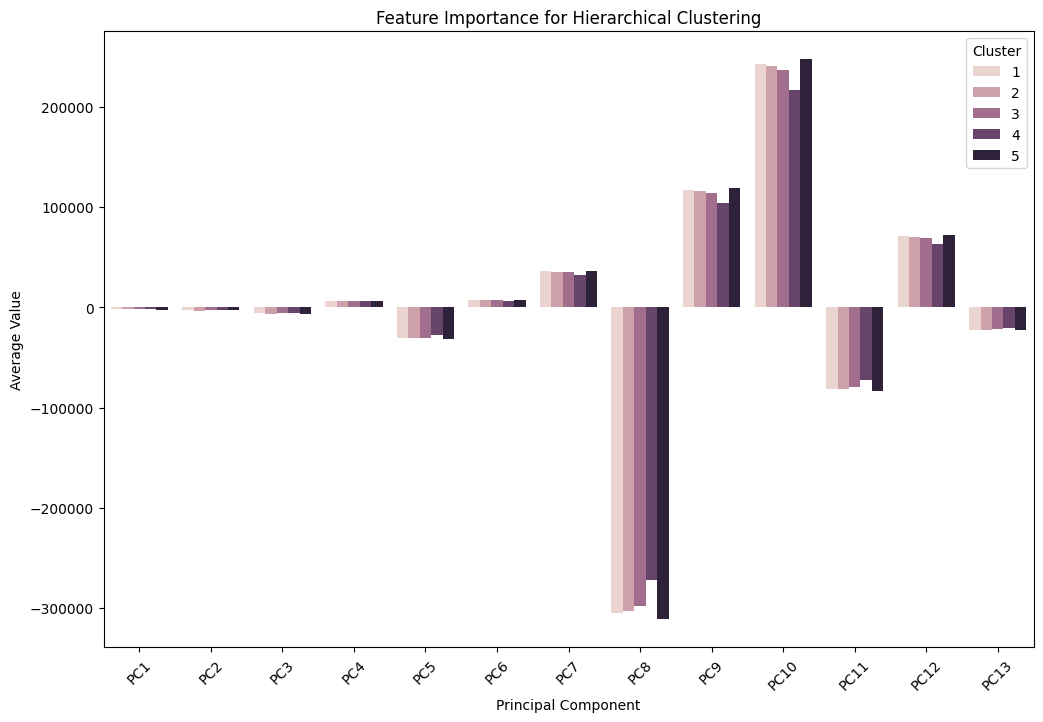

In [20]:
# Calculate average feature values for each cluster
cluster_centers_df = pd.DataFrame(centroids_reduced, columns=[f'PC{i+1}' for i in range(centroids_reduced.shape[1])])
cluster_centers_df['Cluster'] = range(1, n_clusters_hierarchical + 1)

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(data=cluster_centers_df.melt(id_vars='Cluster'), x='variable', y='value', hue='Cluster')
plt.title('Feature Importance for Hierarchical Clustering')
plt.xlabel('Principal Component')
plt.ylabel('Average Value')
plt.legend(title='Cluster')
plt.xticks(rotation=45)
plt.show()

3D vizuelizacija klastera i scatter plot za svaki od klastera

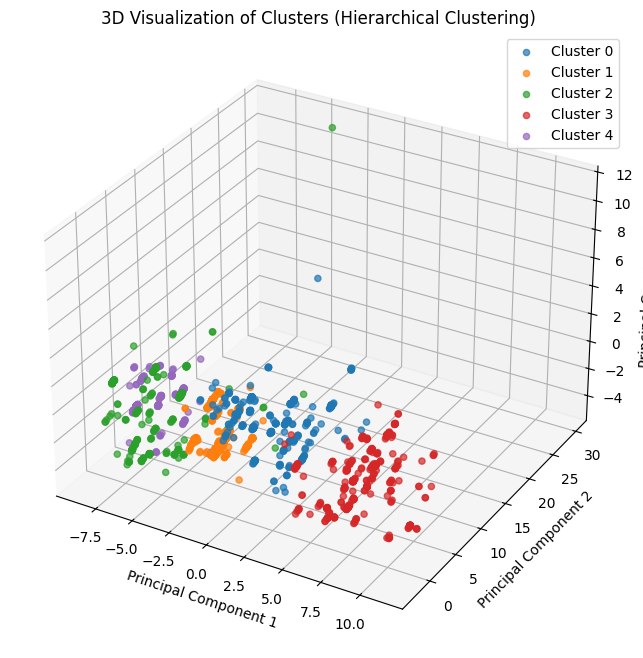

In [21]:
# Visualize clusters in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for each cluster
for cluster in np.unique(hc_clusters):
    cluster_indices = np.where(hc_clusters == cluster)
    ax.scatter(df_reduced[cluster_indices, 0], df_reduced[cluster_indices, 1], df_reduced[cluster_indices, 2], label=f'Cluster {cluster}', alpha=0.7)

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('3D Visualization of Clusters (Hierarchical Clustering)')
plt.legend()
plt.show()

Priprema podataka za treniranje modela Gaussian-mixture

In [22]:
df = pd.read_csv('books.csv')

# Apply outlier transformation using QuantileTransformer
scaler = QuantileTransformer(output_distribution='normal')
df_scaled = scaler.fit_transform(df)

Primena PCA algoritma

In [23]:
# Apply PCA for feature reduction
pca = PCA(n_components=0.95)  # Keep 95% of the variance
df_reduced = pca.fit_transform(df_scaled)

AIC i BIC vizualizacija

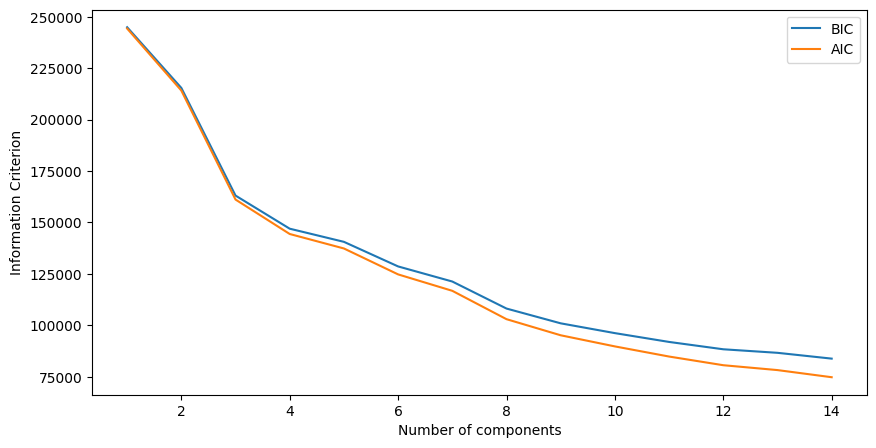

In [24]:
# Assuming df is your DataFrame
n_components = np.arange(1, 15)  # Range of potential cluster numbers
bics = []
aics = []

for n in n_components:
    gmm = GaussianMixture(n_components=n, random_state=0)
    gmm.fit(df_reduced)
    bics.append(gmm.bic(df_reduced))
    aics.append(gmm.aic(df_reduced))

plt.figure(figsize=(10, 5))
plt.plot(n_components, bics, label='BIC')
plt.plot(n_components, aics, label='AIC')
plt.xlabel('Number of components')
plt.ylabel('Information Criterion')
plt.legend()
plt.show()

Primena Gaussian-mixture

In [25]:
# Gaussian Mixture Models
n_clusters_gmm = int(input("Enter the number of clusters for GMM: "))
gmm = GaussianMixture(n_components=n_clusters_gmm, random_state=0)
gmm_clusters = gmm.fit_predict(df_reduced)

# Calculate silhouette score
silhouette_avg_gmm = silhouette_score(df_reduced, gmm_clusters)
print("Silhouette Score for GMM: ", silhouette_avg_gmm)

# Add cluster labels to the original DataFrame
df['cluster'] = gmm_clusters
df.to_csv('books_clustered-gmm.csv', index=False)

Silhouette Score for GMM:  0.26142753653888295


Vizuelizacija centroida klastera

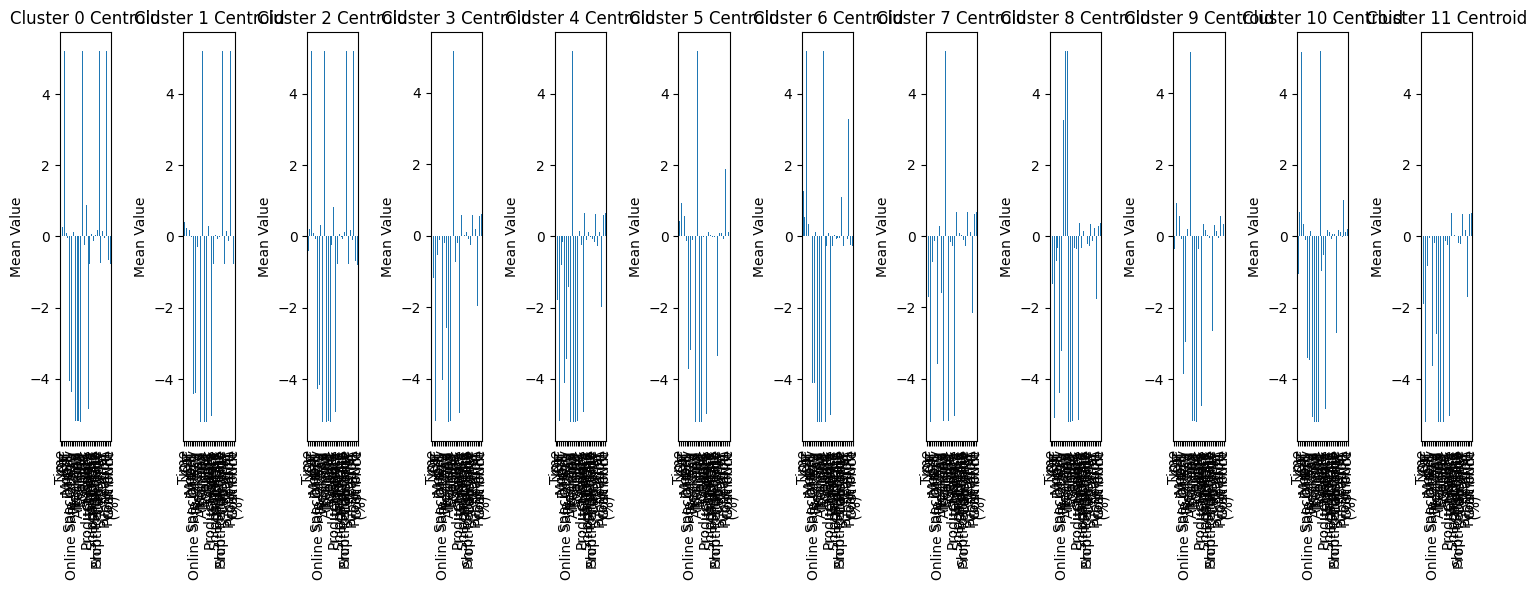

In [26]:
# Analyzing centroids
gmm_centroids = pca.inverse_transform(gmm.means_)  # Transform back to original feature space

# Visualizing centroids
centroids_df = pd.DataFrame(gmm_centroids, columns=df.columns[:-1])
plt.figure(figsize=(15, 6))
for i in range(centroids_df.shape[0]):
    plt.subplot(1, centroids_df.shape[0], i+1)
    centroids_df.iloc[i].plot(kind='bar')
    plt.title(f'Cluster {i} Centroid')
    plt.ylabel('Mean Value')
plt.tight_layout()
plt.show()

Feature importance odredjivanje

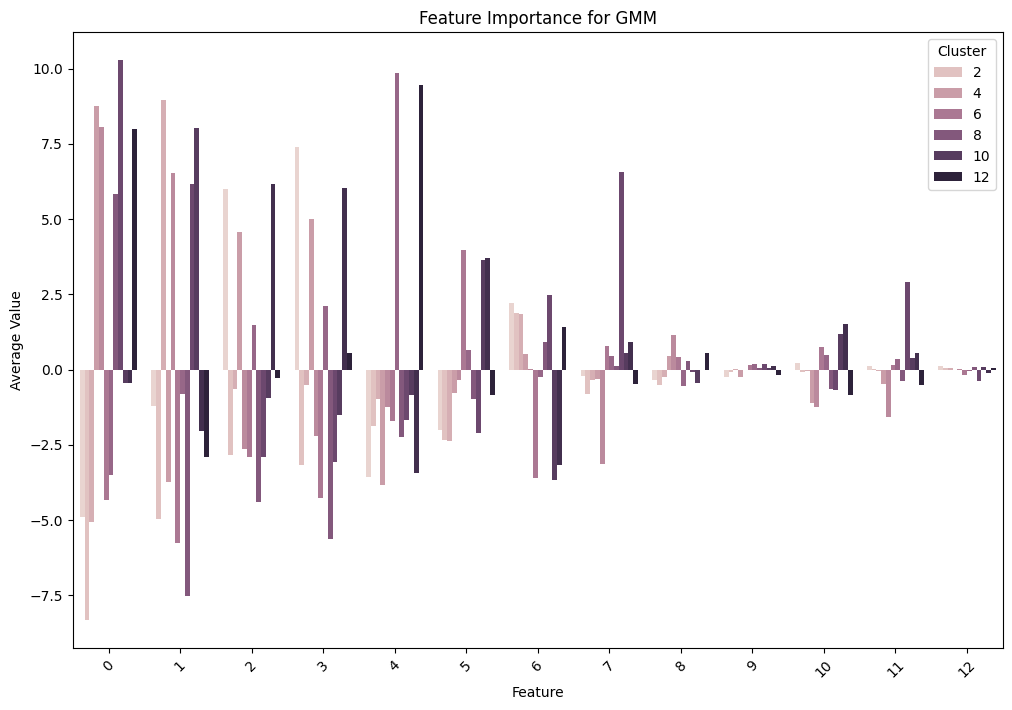

In [27]:
# Calculate average feature values for each cluster
cluster_centers_df = pd.DataFrame(gmm.means_, columns=np.arange(gmm.means_.shape[1]))
cluster_centers_df['Cluster'] = range(1, n_clusters_gmm + 1)

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(data=cluster_centers_df.melt(id_vars='Cluster'), x='variable', y='value', hue='Cluster')
plt.title('Feature Importance for GMM')
plt.xlabel('Feature')
plt.ylabel('Average Value')
plt.legend(title='Cluster')
plt.xticks(rotation=45)
plt.show()

3D vizuelizacija klastera i scatter plot za svaki od klastera

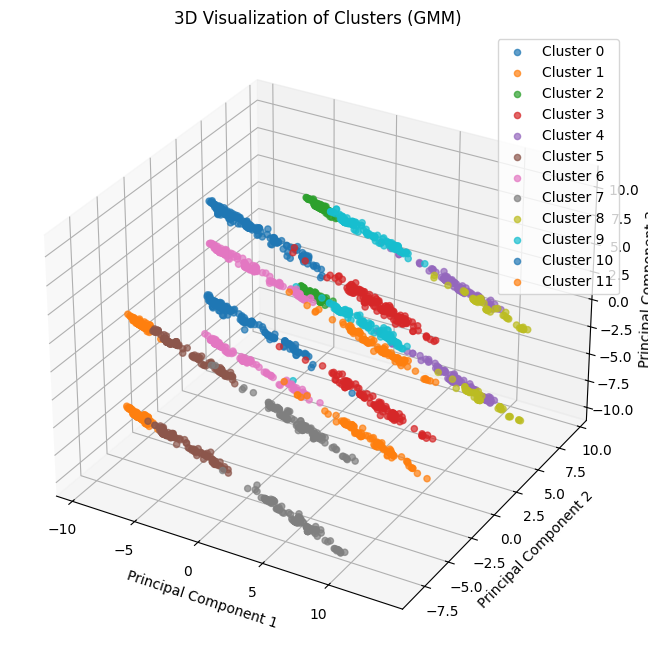

In [28]:
# Visualize clusters in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for each cluster
for cluster in np.unique(gmm_clusters):
    cluster_indices = np.where(gmm_clusters == cluster)
    ax.scatter(df_reduced[cluster_indices, 0], df_reduced[cluster_indices, 1], df_reduced[cluster_indices, 2], label=f'Cluster {cluster}', alpha=0.7)

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('3D Visualization of Clusters (GMM)')
plt.legend()
plt.show()